## <a name="table">Table of Contents</a> 

[0. Load Data](#load_data)  
- [loading all, conservative, liberal](#load_main) 
- [loading train, test](#load_train_test)
- [loading articles and all classes (majority, distribution)](#load_articles)
<br><br>


[I. Finding Strategies per Effect](#finding_strategies)  

   - I.1 [Extract features for lead body and end (liwc, mpqa, nrc, adu, lemmas)](#i1_extract_features) 
    
   - I.2 [Cluster_Analysis](#i2_cluster_analysis) <br>
     - 2.0 [Cluster Analysis - RUN ALL Settings](#i20_cluster_analysis) <br>
     - 2.a [Lead](#i2a_lead) <br>
     - 2.b [Body](#i2b_body) <br>
     - 2.c [End](#i2c_end) <br>
   - I.3 [Mapping Clusters](#i3_mapping_clusters)
     - 3.a [Lead](#i3a_lead) <br>
     - 3.b [Body](#i3b_body) <br>
     - 3.c [End](#i3c_end) <br>
   
[II. Model](#model)

   - II.2 [Using Bert](#bert)
   

In [3]:
import glob
import pandas as pd
import numpy as np
import text_miner
import loader
import topic_modeler as tm

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import DBSCAN
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn import preprocessing
import importlib
import cluster_analysis

import significance_testing
import seaborn as sns
from functools import reduce #python 3
import machine_learning
import lexicons
import utility
import matplotlib
import scipy.stats as stats
import significance_testing

%matplotlib inline
matplotlib.rcParams.update({'font.size': 12})

# <a name="load_data">0. Load Data</a> 
[Back to Table of Contents](#table)

## <a name="load_main">loading all, conservative, liberal</a> 


In [8]:
load = loader.loader()
corpus = load.corpus
#corpus = load.add_ideology_intensity()

"corpus" is set. It contains the 6000 annotation


In [9]:
corpus.head()


,annotator_id,article_id,political_typology,effect,explanation,article_index,change,empower,date_created,political_pole,effect_abstracted,batch,intensity
0,C03,1638699.txt,Country First Conservatives,5,I have made public resolutions that failed and...,0,None,YES,2018-05-04 18:34:14.588362+02,conservative,3,batch1,strong
1,C03,1640113.txt,Country First Conservatives,5,This is one of those that I wouldn’t argue bec...,1,None,NO,2018-05-04 18:34:14.588362+02,conservative,3,batch1,strong
2,C03,1640630.txt,Country First Conservatives,3,"River restoration is nice, I suppose.",2,None,None,2018-05-04 18:34:14.588362+02,conservative,2,batch1,none
3,C03,1640915.txt,Country First Conservatives,2,"I feel like we should be helping the poor, but...",3,None,None,2018-05-04 18:34:14.588362+02,conservative,1,batch1,moderate
4,L07,1638699.txt,Disaffected Democrats,4,I genuinely believe that people need to be act...,0,None,None,2018-05-04 20:24:51.224554+02,liberal,3,batch1,moderate


## <a name="load_articles">loading articles and all classes (majority, distribution)</a> 


In [10]:
df_majority = pd.read_json('data/articles_with_adu_liwc_lexicons.json', orient='records')
df_majority.set_index('idx', inplace=True)
#df_features = df_features[['conservative_majority',  'liberal_majority',]]
df_majority=df_majority[df_majority['split_label']=='train']
df_majority = df_majority[['conservative_majority',  'liberal_majority',]]
df_majority.head()

,conservative_majority,liberal_majority
idx,,
1677322,challenging,reinforcing
1818732,no_effect,reinforcing
1680635,no_effect,reinforcing
1647477,reinforcing,reinforcing
1785853,reinforcing,reinforcing


#  <a name="finding_strategy">I. Finding Strategies per Effect</a>
[Back to Table of Contents](#table)

**Having**
  - LEAD: First 2 paragraphs
  - End: Last paragraph n.
  - Body: Paragraphs 3-(n-1)
  
    1. Get features for lead, body, end.
    2. Cluster lead, body, end each. For example, we would have 3 labels for lead, 5 for body and 3 for end. This leads to 3x5x3 combinations
    3. align cluster labels as strategies for each editorial
    4. stats - het top strategies per effect-ideology
    5. calculate significancy

## <a name="i1_extract_features">1. Extract features for lead body and end </a>



In [11]:
import machine_learning


<module 'loader' from 'C:\\Users\\Roxanne El Baff\\Documents\\projects\\acl2020-news-editorial-analysis\\loader.py'>

In [12]:
pars_features_df = load.load_saved_pars_df()

len(pars_features_df['id'].unique())

setting split_label
setting discourse_level


979

In [13]:
import features
def get_column_types(df):
    cols_map = {
        'liwc': [l for l in df.columns if l.startswith('liwc_')],
        'nrc': [l for l in df.columns if l.startswith('nrc_')],
        'mpqa_arg': [l for l in df.columns if l.startswith('mpqa_arg_')],
        'mpqa_par_sentences': [l for l in df.columns if l.startswith('mpqa_par_sentences')],
        'adu': [l for l in df.columns if l.startswith('adu_')],
    }
 
    return cols_map



def clustering_discourse_level(df, discourse_level='all', normalize=True):#only_numeric for clustering
    cols_map = get_column_types(df).values()
    cols = reduce(lambda x,y: x+y,cols_map)
    df_ = df[df['discourse_level'] == discourse_level] if discourse_level != 'all' else df

    df_ = df_[df_['split_label'] == 'train']
    cluster_df = df_.copy()
    

    cluster_df = df_.set_index('id')
    cluster_df = cluster_df[cols]
    cluster_df = cluster_df.groupby(['id'], as_index=True).sum()
    
    ## Normalize for only training set for discourse level
    cluster_df, _ = machine_learning.clip_outliers(cluster_df, df_test =None, lower_percentile=1,  upper_percentile=99)
    if normalize:
        cluster_df, _ = machine_learning.normalize(cluster_df, None, normalizing_method="sqrt")
    return cluster_df
    

## <a name="i2_cluster_analysis">2. Cluster Analysis</a>



In [14]:
import visualization

<module 'significance_testing' from 'C:\\Users\\Roxanne El Baff\\Documents\\projects\\acl2020-news-editorial-analysis\\significance_testing.py'>

### <a name="i20_cluster_analysis">2.0 Cluster Analysis - RUN ALL Settings</a>

In [15]:
import itertools

def get_cols_from_types(df, feature_type_comb):
    all_cols = get_column_types(df)
    aktuell_cols = []
    for feature_type in feature_type_comb:
        aktuell_cols.extend(all_cols[feature_type])
    return aktuell_cols

def run_cluster_analysis_preset_col(df, feature_type_comb=None):
    if feature_type_comb is None:
        feature_type_comb = get_column_types(df).keys()
    aktuell_cols = get_cols_from_types(df, feature_type_comb)
    print()
    print(str(feature_type_comb))
    k_optimal = cluster_analysis.elbow(df[aktuell_cols], normalize=True)
    return k_optimal

def run_cluster_analysis_all_comb(df):    
    all_cols = get_column_types(df)
    res = []
    for i in range(1, len(all_cols.keys())+1):
        combs = list(itertools.combinations(all_cols.keys(), i))
        for comb in combs:
            aktuell_cols = get_cols_from_types(df, comb)
            k_optimal = run_cluster_analysis_preset_col(df, feature_type_comb=comb)
            analyzer_coskmeans = cluster_analysis.Analyzer(df[aktuell_cols])
            analyzer_coskmeans.set_algorithm(algorithm= 'cosine_kmeans', algorithm_args={'n_clusters':k_optimal})
            score = analyzer_coskmeans.evaluate_silhouette_score(metric="cosine")
            res.append({'feature_types':comb, 'k': k_optimal,  'silhouette':score})
    res_df = pd.DataFrame.from_dict(res)
   
    res_df = res_df.sort_values(by=['silhouette', 'k'], ascending=False)
    return res_df

# [ 'mpqa_args', 'mpqa_subj', 'mpqa_sentiment', 'nrc', 'liwc',  'adus']
def run_cluster_analysis_one_col(df):    
    res = []

    for k, cols in get_column_types(df).items():
        res += '\ncolumn type'+ str(k) +  ' with ' + str(len(cols))+ ' columns:'
        print('column type', k, ' with ', len(cols), ' columns:')
        #cluster_analysis.elbow(lead_cluster_df[cols], normalize=False, k_range = range(2, 10 ))
        k_optimal = cluster_analysis.elbow(df[cols], normalize=True, k_range = range(2, 10 ))
        res.append(k_optimal)
    print(res)



In [16]:
## SETTING for clustering
# either using all feature types or best obne or best 2
settings_dic = {'all': { ## all features
                            'lead': [ 'mpqa_args', 'mpqa_subj', 'mpqa_sentiment', 'nrc', 'liwc',  'adus'],
                            'body': [ 'mpqa_args', 'mpqa_subj', 'mpqa_sentiment', 'nrc', 'liwc',  'adus'],
                            'end': [ 'mpqa_args', 'mpqa_subj', 'mpqa_sentiment', 'nrc', 'liwc',  'adus'],
                            },
               'best': { ## feature type with best sillhouette score (based on run_cluster_analysis_all_comb)
                            'lead': [  'adus'],
                            'body': [ 'mpqa_sentiment' ],
                            'end':  ['mpqa_subj']
                            },
               'best2':  { # at least 2 feature types with best silhouette score ((based on run_cluster_analysis_all_comb))
                            'lead': [  'mpqa_subj','adus'],
                            'body': [  'mpqa_subj','adus'],
                            'end':  [  'mpqa_subj','adus']
                            }
               }

setting_all= {}
setting_all['all'] = settings_dic['all']

In [ ]:
pars_features_df['discourse_level']

In [112]:
####################
####  HELPERS   ####
####################
def get_article_flow_df(predicted_dict):    
    article_flow = pd.DataFrame(columns = [ 'flow', 'id'])#lead_predicted_labels.copy()
    article_flow.set_index('id', inplace=True)
    for idx, row in predicted_dict['lead'].iterrows():
        body_cluster = predicted_dict['body'].loc[idx]['cluster'] if idx in predicted_dict['body'].index else 'body:'
        end_cluster = predicted_dict['end'].loc[idx]['cluster'] if idx in predicted_dict['end'].index else 'end:'
        flow = row['cluster'] + body_cluster + end_cluster
        article_flow.loc[idx]= flow

    return article_flow

def apply_flow(row, predicted_dic, article_flow):
    a_id = row.name
    row['flow'] =  article_flow.loc[a_id]['flow']
    row['lead_cluster'] =  predicted_dic['lead'].loc[a_id]['cluster']
    row['body_cluster'] =  predicted_dic['body'].loc[a_id]['cluster'] if a_id in predicted_dic['body'].index else ''
    row['end_cluster'] =  predicted_dic['end'].loc[a_id]['cluster']
    return row

####################################################################################################
####    Run cluster analysis for several settings > generate flows > labels on training data    ####
####################################################################################################
importlib.reload(cluster_analysis)
def run_cluster_analysis(ideology_a_articles_df, 
                     ideology_b_articles_df, df,
                    desc = "default"):
    single_setting_predictions = {}
    significancy_result= {}
    for discourse_level in ['lead', 'body', 'end']:

        ## INIT
        df_ = clustering_discourse_level(df, discourse_level=discourse_level, normalize=False)


        print('filtering our features wich has 75% of entries without a values')
        df_ = df_.loc[:,~df_.columns.duplicated()]
        desc_df= df_.describe().T
        desc_df= desc_df[desc_df['75%'] > 0]

        df_ = df_[desc_df.index.values]
        #desc_.index.values 
        ## CLUSTER ANALYSIS
        optimal_k = cluster_analysis.elbow(df_,normalize = True, visualize=False )

        analyzer_cos_kmeans = cluster_analysis.Analyzer(df_)
        analyzer_cos_kmeans.set_algorithm(algorithm= 'cosine_kmeans', algorithm_args={'n_clusters':optimal_k})
        analyzer_cos_kmeans.evaluate_silhouette_score(metric="cosine")
        #cluster_lbl_ = analyzer_cos_kmeans.predict_labels('id')

        ## PREDICT LABEL
        predicted_df = analyzer_cos_kmeans.predict_labels('id', apply=True)
        print('Plotting for:')
        print(analyzer_cos_kmeans.top_vars('id', top=4, plot=True))
        single_setting_predictions[discourse_level] = predicted_df

        ## Significance Testing - 
        ## H0: There is no significance difference between features (e.g. Liwc tone)
        ##  across all clusters for ONE discourse level/setting
        ## EXAMPLE of H0: There is no significance difference between Liwc emotional tone 
        ##                across all cluster types for LEAD.
        significancy_result[discourse_level] =significance_testing.significance(analyzer_cos_kmeans.df, #save=False, 
                                          #desc='significance_tests/{}/sigtest_{}'.format(desc, discourse_level),
                                          independent_var='cluster')
    article_flow_df = get_article_flow_df(single_setting_predictions)

    ideology_a_articles_df = ideology_a_articles_df.apply(apply_flow,  args=(single_setting_predictions,  article_flow_df),
                                                                          axis=1)
    ideology_b_articles_df = ideology_b_articles_df.apply(apply_flow, 
                                                                          args=(single_setting_predictions, 
                                                                                article_flow_df),
                                                                          axis=1)
    return significancy_result, ideology_a_articles_df, ideology_b_articles_df


def run_stats_lib_gg_cons(con_df, lib_df):
    # For each effect/cluster(lead, body, end, flow), check if liberal is sign. different than cons
    effects = list(lib_df['majority'].unique())
    ivs = ['flow', 'lead_cluster', 'body_cluster', 'end_cluster']
    for k in settings_dic.keys():
        for iv in ivs :
            for effect in effects:
                cons_df_ = con_df.copy()[[iv, effect]]
                lib_df_ = lib_df.copy()[[iv, effect]]
                significance_testing.significance(original_df, features, save = False,
                                                  desc='', independent_var='cluster')

   
    

getting only numeric features from the training set...
There are 128  numeric features out of 128
filtering our features wich has 75% of entries without a values
cosine_kmeans - silhouette_score: 0.31769145210224925
0.25.2
Plotting for:
88
88


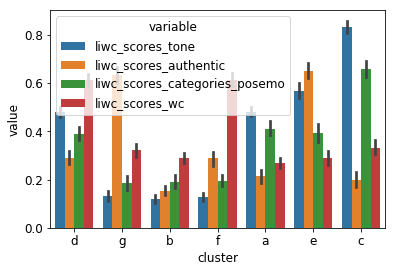

                         Variable       Var
67               liwc_scores_tone  0.254082
1           liwc_scores_authentic  0.191975
45  liwc_scores_categories_posemo  0.159696
68                 liwc_scores_wc  0.142322
data has 783 instances
bonforrini_threshold:  0.002380952380952381
getting only numeric features from the training set...
There are 128  numeric features out of 128
filtering our features wich has 75% of entries without a values
cosine_kmeans - silhouette_score: 0.3144226230568439
0.25.2
Plotting for:
96
96


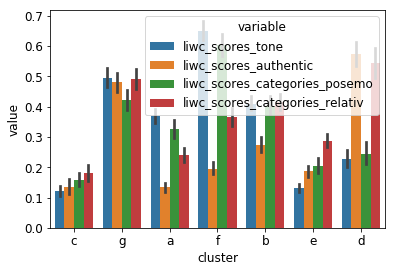

                          Variable       Var
72                liwc_scores_tone  0.181024
1            liwc_scores_authentic  0.162569
49   liwc_scores_categories_posemo  0.141623
55  liwc_scores_categories_relativ  0.123243
data has 782 instances
bonforrini_threshold:  0.002380952380952381
getting only numeric features from the training set...
There are 128  numeric features out of 128
filtering our features wich has 75% of entries without a values
cosine_kmeans - silhouette_score: 0.3447662621566162
0.25.2
Plotting for:
79
79


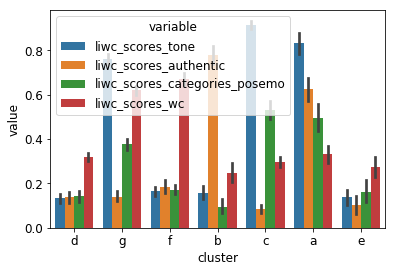

                         Variable       Var
59               liwc_scores_tone  0.342242
1           liwc_scores_authentic  0.263429
38  liwc_scores_categories_posemo  0.168316
60                 liwc_scores_wc  0.161306
data has 783 instances
bonforrini_threshold:  0.002380952380952381


In [113]:
train_liberal_articles_df = df_majority[['liberal_majority']]

train_conservative_articles_df = df_majority[['conservative_majority']]
significancy_result, train_liberal_articles_df, train_conservative_articles_df = run_cluster_analysis(train_liberal_articles_df, 
                     train_conservative_articles_df, pars_features_df,
                      desc='normalized_allfeatures')

In [ ]:
def apply_effective(row, label):
    row['is_effective'] = False if (row[label] == 'no_effect') else True
    return row

train_liberal_articles_df = train_liberal_articles_df.apply(apply_effective, args=('liberal_majority',),axis=1)
train_conservative_articles_df = train_conservative_articles_df.apply(apply_effective, args=('conservative_majority',),axis=1)


In [155]:
def get_distr(col):
    
    col = round(col/sum(col.values), 2)
    
    return col
def add_sum(row):
    row['sum'] = row.values.sum()
    return row

def count_cluster(lib_df, conv_df, cluster):
    lib = pd.crosstab(lib_df[cluster], lib_df['liberal_majority'])
    cons = pd.crosstab(conv_df[cluster], conv_df['conservative_majority'])
    all_df =  lib.join(cons, how="outer", lsuffix ='_lib', rsuffix = "_cons")
    all_df = all_df[['challenging_lib', 'no_effect_lib', 'reinforcing_lib', 'challenging_cons', 'no_effect_cons', 
                     'reinforcing_cons']]
    all_df=all_df.apply(add_sum, axis=1)
    dstr_df = all_df.apply(get_distr, axis=0)
    return all_df, dstr_df

count_lead, dstr_lead=count_cluster(train_liberal_articles_df, train_conservative_articles_df, 'lead_cluster')

count_body, dstr_body=count_cluster(train_liberal_articles_df, train_conservative_articles_df, 'body_cluster')
count_end, dstr_end =count_cluster(train_liberal_articles_df, train_conservative_articles_df, 'end_cluster')
count_flow, dstr_flow =count_cluster(train_liberal_articles_df, train_conservative_articles_df, 'flow')

#count_flow.sort_values(by=['sum'], ascending=False).to_csv('4dec_flows.csv')


In [115]:
count_lead

,challenging_lib,no_effect_lib,reinforcing_lib,challenging_cons,no_effect_cons,reinforcing_cons,sum
lead_cluster,,,,,,,
a,16,17,80,19,39,55,226
b,25,11,81,23,42,52,234
c,19,14,61,15,36,43,188
d,30,27,91,21,55,72,296
e,8,21,77,13,48,45,212
f,14,13,73,21,35,44,200
g,14,15,76,16,37,52,210


In [116]:
dstr_lead[cs]

,challenging_lib,no_effect_lib,reinforcing_lib
lead_cluster,,,
a,0.13,0.14,0.15
b,0.20,0.09,0.15
c,0.15,0.12,0.11
d,0.24,0.23,0.17
e,0.06,0.18,0.14
f,0.11,0.11,0.14
g,0.11,0.13,0.14


In [159]:
#cs= [c for c in count_lead.columns.values if c.endswith('_lib')]
a = 'no_effect_lib'
b= 'reinforcing_lib'
#obs =count_flow[((count_flow[a] > 0 ) &  (count_flow[b] > 0))]
obs = count_flow[[a,b]]
stats.chisquare(obs[a].values, obs[b].values)


array([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 2, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 3, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 0,
       0, 1, 0, 0, 2, 1, 0, 0, 2, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 3,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 2, 0, 1, 1, 3, 1, 0, 1, 0, 2, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 2, 2, 1, 0, 1, 0, 0, 0, 3, 1, 2, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 2, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 3, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 2, 1], dtype=int64)

In [59]:
print(list(train_conservative_articles_df['lead_cluster'].value_counts()))

[183, 161, 134, 104, 103, 97]


In [ ]:
#count_clusters_poi_ideo['all_flow'].sort_values(by=['liberal_reinforcing'], ascending=False).to_csv('flows.csv')

In [58]:
from scipy.stats import chisquare

chisquare(list(train_conservative_articles_df['lead_cluster'].value_counts()))# H0: Clusters are equally Distributed rejected at p<0.001 (statistic=43.855, pvalue=2.4786323025345345e-08)

Power_divergenceResult(statistic=48.17902813299233, pvalue=3.265235909352374e-09)

In [ ]:
## FOR LEAD BODY END : with each pole, H0: There is no different with cluster type on the effect
## Liberal:
# H0: Editorial's effect is not associated with cluster type
def sigtest_clusters_within_effect(df, target):
    pois = ['flow', 'lead_cluster', 'body_cluster', 'end_cluster']
    #effects = ['reinforcing', 'challenging', 'all_body_cluster', 'all_end_cluster']
    #vs = df['majority'].unique()

    effects = list(df[target].unique())
    for poi in pois:
        for effect, effect_df in df.groupby(target):
            
           
            counts = list(effect_df[poi].value_counts().values)
            if all(i >= 5 for i in counts):
                x, p_value = chisquare(counts)
                if p_value<0.05:
                    print()
                    print(poi, ' ', effect )

                    print('For {} with effect: {} - p value is < 0,05: {} with p_value={} and X2={}'.format(poi,
                                                                                                     effect,
                                                                                                     str(p_value<0.05),
                                                                                                     str(round(p_value,20)),
                                                                                                     str(round(x,2))))
            #else:
                
                #print("CAN NOT USE CHISQUARE! {} {}".format(poi,effect))

#sigtest_clusters_within_effect(train_conservative_articles_df)    
#all(i >= 5 for i in [8,5,7])
#(train_liberal_articles_df['all_body_cluster'].value_counts())

In [123]:
import scipy.stats as stats
# Effect is not associated with cluster
def within_political(df, var1, var2, alfa=0.05):
    
    cross_tab = pd.crosstab(df[var1], df[var2])
    #r, p_value = stats.fisher_exact(cross_tab.values)#chi2_contingency(cross_tab)
    chi_square, p_value, df, expected= stats.chi2_contingency(cross_tab)
    if p_value<alfa:
        print("p_value: {}".format(str(round(p_value, 2))))
    

def across(lib_df, conv_df, cluster, alfa = 0.05):
    lib = pd.crosstab(lib_df[cluster], lib_df['liberal_majority'])
    cons = pd.crosstab(conv_df[cluster], conv_df['conservative_majority'])
    all_df =  lib.join(cons, how="outer", lsuffix ='_lib', rsuffix = "_cons")
    effects = ['challenging',  'no_effect','reinforcing']
    all_df.reset_index(inplace=True)#
    all_df.replace('', np.nan, inplace=True)
    all_df.dropna(inplace=True)
    all_df = all_df.set_index(cluster)
    all_df = all_df[(all_df.T != 0).any()]
    #return all_df
    for effect in effects:
        df = all_df[[effect+'_lib', effect+'_cons']]
        df = df[(df.T != 0).any()]
        chi_square, p_value, df, expected = stats.chi2_contingency(df)
        #if p_value < alfa:
        print("effect {} - cluster: {} - p_value: {}".format(effect, 
                                                             cluster,
                                                             str(round(p_value, 10))))

In [124]:
## add all comb
def apply_add_flows (row):
    row['flow_lead_body'] = row['lead_cluster'] + row['body_cluster'] 
    row['flow_lead_end'] = row['lead_cluster'] + row['end_cluster'] 
    row['flow_body_end'] = row['body_cluster'] + row['end_cluster'] 
    return row
train_conservative_articles_df = train_conservative_articles_df.apply(apply_add_flows, axis=1)
train_liberal_articles_df = train_liberal_articles_df.apply(apply_add_flows, axis=1)

#train_extreme_articles_df = train_extreme_articles_df.apply(apply_add_flows, axis=1)
#train_lean_articles_df = train_lean_articles_df.apply(apply_add_flows, axis=1)

In [125]:
train_conservative_articles_df
pd.crosstab(train_conservative_articles_df['conservative_majority'], 
            train_conservative_articles_df['lead_cluster']).values #'majority', 'flow_lead_body')



array([[19, 23, 15, 21, 13, 21, 16],
       [39, 42, 36, 55, 48, 35, 37],
       [55, 52, 43, 72, 45, 44, 52]], dtype=int64)

In [126]:
train_liberal_articles_df = train_liberal_articles_df[train_liberal_articles_df['body_cluster'] != '']
train_conservative_articles_df = train_conservative_articles_df[train_conservative_articles_df['body_cluster'] != '']

In [136]:
def run_within_cross_chitests(a_df, b_df, a, b):
    for flow in [ 'flow']:
        print(flow, ' - ', a)
        within_political(a_df, a+'_'+'majority', flow)
        print()

       
    


In [137]:
#run_within_cross_chitests(train_lean_articles_df, train_extreme_articles_df, 'lean', 'extreme')
run_within_cross_chitests(train_liberal_articles_df, train_conservative_articles_df, 'liberal', 'conservative')

flow  -  liberal
p_value: 0.01

